In [1]:
# Package dependencies:

# https://github.com/felixpatzelt/priceprop/
# https://github.com/anabugaenko/liquidity

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from typing import Dict, Tuple
from IPython.display import display
from matplotlib import pyplot as plt


from liquidity.features import compute_aggregate_features
from liquidity.finite_scaling.fit import fit_scaling_form, fit_scaling_law
from liquidity.impact import aggregate_impact,  compute_impact_from_returns
from liquidity.finite_scaling.fss import mapout_scale_factors, transform, find_scale_factors
from liquidity.util.plot_utils import plot_scaling_function, plot_collapsed_scaling_function

In [3]:
import priceprop.batch as pb

In [4]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

# Nonlinear aggregate impact from linear propagator models

See:

Patzelt, F. and Bouchaud, J.P., 2018. Universal scaling and nonlinearity of </br>
aggregate price impact in financial markets. Physical Review E, 97(1), p.012304.</br>

Patzelt, Felix, and Jean-Philippe Bouchaud. "Nonlinear price impact from linear models."</br>
Journal of Statistical Mechanics: Theory and Experiment 2017, no. 12 (2017): 123404.</br>

### Load the data

In [5]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL', 'GOOG']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_data = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_data[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_data['TSLA']
amzn_raw_df = stock_data['AMZN']
nflx_raw_df = stock_data['NFLX']
msft_raw_df = stock_data['MSFT']
ebay_raw_df = stock_data['EBAY']
aapl_raw_df = stock_data['AAPL']
goog_raw_df = stock_data['GOOG']

In [6]:
aapl_raw_df.head()

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,R1,R1_uncond,R1_cond,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:00.544161131,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,0.00,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
1,1,2017-01-03 10:30:02.758712611,-1,BID,REMOVE,True,115.69,153,115.70,115.69,...,0.01,0.01,-0.01,0.01,2017-01-03,0.004271,1398089,6170,0.200739,-153
2,2,2017-01-03 10:30:02.852790059,1,ASK,REMOVE,True,115.69,200,115.69,115.68,...,0.01,0.01,0.01,0.01,2017-01-03,0.004271,1398089,6170,0.191380,200
3,3,2017-01-03 10:30:04.539218241,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,0.00,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
4,4,2017-01-03 10:30:07.865732286,1,ASK,UPDATE,True,115.70,10,115.70,115.69,...,0.00,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.009569,10


In [7]:
aapl_raw_df[["event_timestamp", "midprice", "R1_uncond", "R1_cond", "sign"]]

,event_timestamp,midprice,R1_uncond,R1_cond,sign
0,2017-01-03 10:30:00.544161131,115.695,0.000,0.000,1
1,2017-01-03 10:30:02.758712611,115.695,0.010,-0.010,-1
2,2017-01-03 10:30:02.852790059,115.685,0.010,0.010,1
3,2017-01-03 10:30:04.539218241,115.695,0.000,0.000,1
4,2017-01-03 10:30:07.865732286,115.695,0.000,0.000,1
...,...,...,...,...,...
2633973,2017-12-29 14:59:22.595997049,169.985,0.005,0.005,1
2633974,2017-12-29 14:59:26.825179397,169.990,0.005,0.005,1
2633975,2017-12-29 14:59:58.621436793,169.995,-0.000,0.000,-1
2633976,2017-12-29 14:59:58.621758027,169.995,0.010,-0.010,-1


## Generate true aggregate impact
From raw order book series, compute aggregate features, where impact and imbalance or normalized by their correpsonding daily or average values.

In [8]:
imbalance_column = "sign_imbalance"

In [9]:
conditional_aggregate_impact = aggregate_impact(aapl_raw_df, [1], imbalance_column=imbalance_column)
conditional_aggregate_impact

,event_timestamp,Unnamed: 0,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,daily_vol,daily_num,norm_size,signed_volume,sign_imbalance,volume_imbalance,price_change_imbalance,R_cond,R_uncond,T
0,2017-01-03 10:30:02.758712611,1,-1,BID,REMOVE,True,115.69,153,115.70,115.69,...,1398089,6170,0.200739,-153,-0.000162,-153,True,-2.341556,0.010,1
1,2017-01-03 10:30:02.852790059,2,1,ASK,REMOVE,True,115.69,200,115.69,115.68,...,1398089,6170,0.191380,200,0.000162,200,True,2.341556,0.010,1
2,2017-01-03 10:30:04.539218241,3,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1398089,6170,0.095690,100,0.000162,100,True,0.000000,0.000,1
3,2017-01-03 10:30:07.865732286,4,1,ASK,UPDATE,True,115.70,10,115.70,115.69,...,1398089,6170,0.009569,10,0.000162,10,False,0.000000,0.000,1
4,2017-01-03 10:30:08.360855091,5,1,ASK,UPDATE,True,115.70,300,115.70,115.69,...,1398089,6170,0.287070,300,0.000162,300,False,0.000000,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633722,2017-12-29 14:59:22.595997049,6730,1,ASK,REMOVE,True,169.99,200,169.99,169.98,...,1452499,6735,0.258699,200,0.000148,200,True,0.163570,0.005,1
2633723,2017-12-29 14:59:26.825179397,6731,1,ASK,REMOVE,True,170.00,1200,170.00,169.98,...,1452499,6735,1.552195,1200,0.000148,1200,True,0.163570,0.005,1
2633724,2017-12-29 14:59:58.621436793,6732,-1,BID,UPDATE,True,169.99,300,170.00,169.99,...,1452499,6735,0.413298,-300,-0.000148,-300,False,0.000000,-0.000,1
2633725,2017-12-29 14:59:58.621758027,6733,-1,BID,REMOVE,True,169.99,205,170.00,169.99,...,1452499,6735,0.282421,-205,-0.000148,-205,True,-0.327140,0.010,1


## Calibrate propagator 
We obtained $R(x, T)$ by simulating the calibrated models as dynamical systems out-of-sample with real order-flows as inputs.

In [10]:
conditional_aggregate_impact["date"] = conditional_aggregate_impact["event_timestamp"].apply(lambda x: x.date())

trades = conditional_aggregate_impact[["event_timestamp","date", "R_cond", "sign", "price_changing", "midprice", "daily_R1"]]
trades = trades.rename(columns={"R_cond": "r1", "price_changing": "change"})
# trades['sample'] = trades["date"].apply(lambda x: x.day % 2)

In [11]:
db = {'tt': trades}

In [12]:
pb.calc_models(db, nfft='pad > 300', group=True, calibrate=True, split_by=None)

In [13]:
db['tt'].head(5)

,event_timestamp,date,r1,sign,change,midprice,daily_R1,sc,sn,r_cim,r_tim1,r_tim2,r_hdim2,r_hdim2_x2
0,2017-01-03 10:30:02.758712611,2017-01-03,-2.341556,-1,True,115.695,0.004271,-1,0,-1.0,-0.968091,-1.634069,-1.602001,-1.632554
1,2017-01-03 10:30:02.852790059,2017-01-03,2.341556,1,True,115.685,0.004271,1,0,1.0,0.967541,1.715376,1.718707,1.702091
2,2017-01-03 10:30:04.539218241,2017-01-03,0.000000,1,True,115.695,0.004271,1,0,1.0,0.987456,1.716593,1.521840,1.726047
3,2017-01-03 10:30:07.865732286,2017-01-03,0.000000,1,False,115.695,0.004271,0,1,0.0,0.965048,-0.038148,-0.000000,-0.000000
4,2017-01-03 10:30:08.360855091,2017-01-03,0.000000,1,False,115.695,0.004271,0,1,0.0,0.947509,0.484254,0.000000,0.000000


### Extract model predictions

In [14]:
hdim2_predictions = db['tt'][["event_timestamp", "r_hdim2_x2", "r1"]]

# Rename returns predictions to use further downstream
hdim2_predictions["R1_cond"] = hdim2_predictions["r_hdim2_x2"]
hdim2_predictions

,event_timestamp,r_hdim2_x2,r1,R1_cond
0,2017-01-03 10:30:02.758712611,-1.632554,-2.341556,-1.632554
1,2017-01-03 10:30:02.852790059,1.702091,2.341556,1.702091
2,2017-01-03 10:30:04.539218241,1.726047,0.000000,1.726047
3,2017-01-03 10:30:07.865732286,-0.000000,0.000000,-0.000000
4,2017-01-03 10:30:08.360855091,0.000000,0.000000,0.000000
...,...,...,...,...
2633722,2017-12-29 14:59:22.595997049,1.780978,0.163570,1.780978
2633723,2017-12-29 14:59:26.825179397,1.799204,0.163570,1.799204
2633724,2017-12-29 14:59:58.621436793,-0.000000,0.000000,-0.000000
2633725,2017-12-29 14:59:58.621758027,-2.292979,-0.327140,-2.292979


In [9]:
import pickle

# with open("prop_predictions.pkl", "wb") as f:
#             pickle.dump(hdim2_predictions, f)

In [10]:
hdim2_predictions = pickle.load(open("prop_predictions.pkl", "rb"))

## Compute aggregate price response from model returns

In [17]:
BINNING_FREQUENCIES = [10, 20, 50, 100]

In [18]:
hdim2_predictions

,event_timestamp,r_hdim2_x2,r1,R1_cond
0,2017-01-03 10:30:02.758712611,-1.632554,-2.341556,-1.632554
1,2017-01-03 10:30:02.852790059,1.702091,2.341556,1.702091
2,2017-01-03 10:30:04.539218241,1.726047,0.000000,1.726047
3,2017-01-03 10:30:07.865732286,-0.000000,0.000000,-0.000000
4,2017-01-03 10:30:08.360855091,0.000000,0.000000,0.000000
...,...,...,...,...
2633722,2017-12-29 14:59:22.595997049,1.780978,0.163570,1.780978
2633723,2017-12-29 14:59:26.825179397,1.799204,0.163570,1.799204
2633724,2017-12-29 14:59:58.621436793,-0.000000,0.000000,-0.000000
2633725,2017-12-29 14:59:58.621758027,-2.292979,-0.327140,-2.292979


In [19]:
prop_aggregate_impact = compute_impact_from_returns(aapl_raw_df, returns=hdim2_predictions, bin_frequencies=[10, 20, 50, 100], imbalance_column=imbalance_column)

In [20]:
prop_aggregate_impact 

,level_0,index,event_timestamp,midprice,sign,signed_volume,price_changing,daily_R1,daily_num,daily_vol,R_cond,R_uncond,sign_imbalance,volume_imbalance,price_change_imbalance,average_num_at_best,average_vol_at_best,T
0,0,0,2017-01-03 10:30:02.758712611,115.695,-1,-153,True,0.004271,6170,1398089,3.915595,0.03,0.001297,727,4,6.032068,762.184840,10
1,1,1,2017-01-03 10:30:10.822214435,115.705,1,130,True,0.004271,6170,1398089,4.468744,0.06,0.000324,258,7,7.283424,1045.040418,10
2,2,2,2017-01-03 10:30:19.782301269,115.725,1,396,False,0.004271,6170,1398089,-0.449017,0.05,0.000000,396,7,7.283424,1045.040418,10
3,3,3,2017-01-03 10:30:28.753651077,115.735,-1,-100,False,0.004271,6170,1398089,0.606671,0.03,0.000648,709,4,6.032068,762.184840,10
4,4,4,2017-01-03 10:30:34.132511059,115.755,1,174,True,0.004271,6170,1398089,-1.624856,0.06,0.000324,2855,5,7.283424,1045.040418,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475033,64,26333,2017-12-29 14:33:30.204295198,169.975,1,4,True,0.030568,6735,1452499,6.389654,0.44,-0.000594,-7248,46,3.711482,773.098946,100
475034,65,26334,2017-12-29 14:40:18.608198426,169.985,-1,-825,True,0.030568,6735,1452499,-21.964465,0.47,-0.001188,-6037,46,3.890007,725.867637,100
475035,66,26335,2017-12-29 14:46:51.720297104,169.955,-1,-100,False,0.030568,6735,1452499,-3.618869,0.53,-0.002376,-4952,51,3.890007,725.867637,100
475036,67,26336,2017-12-29 14:53:10.420704849,169.955,1,251,False,0.030568,6735,1452499,4.016664,0.52,0.001485,-335,56,3.711482,773.098946,100


In [21]:
cols = ["event_timestamp", "T", "midprice", imbalance_column, "daily_R1", "R_cond"]
prop_aggregate_impact[cols].head(10)

,event_timestamp,T,midprice,sign_imbalance,daily_R1,R_cond
0,2017-01-03 10:30:02.758712611,10,115.695,0.001297,0.004271,3.915595
1,2017-01-03 10:30:10.822214435,10,115.705,0.000324,0.004271,4.468744
2,2017-01-03 10:30:19.782301269,10,115.725,0.000000,0.004271,-0.449017
3,2017-01-03 10:30:28.753651077,10,115.735,0.000648,0.004271,0.606671
4,2017-01-03 10:30:34.132511059,10,115.755,0.000324,0.004271,-1.624856
5,2017-01-03 10:30:54.620450561,10,115.735,0.000324,0.004271,0.583606
6,2017-01-03 10:31:06.452378067,10,115.725,0.000324,0.004271,-1.300901
7,2017-01-03 10:31:19.340815866,10,115.715,-0.000324,0.004271,-0.429700
8,2017-01-03 10:31:45.496858421,10,115.745,-0.000972,0.004271,-4.955413
9,2017-01-03 10:32:12.895557300,10,115.745,0.000972,0.004271,1.459974


## Do FSS by method of Least-squares
Perform FSS where returns data generating processing is assumed to be the propagator 

In [22]:
# Produce propagator predictions 
# for critical scaling exponents
T_values = prop_aggregate_impact['T'].values
imbalance_values = prop_aggregate_impact[imbalance_column].values
R_values = prop_aggregate_impact['R_cond'].values

# Retrive predicted params for all Ts in data
params = fit_scaling_law(T_values, imbalance_values, R_values, reflect_y=False)

In [23]:
# Otimized parameters
chi, kappa, alpha, beta, CONST = params
print(f'chi: {chi}')
print(f'kappa: {kappa}')
print(f'alpha: {alpha}')
print(f'beta: {beta}')

chi: 0.491722048929361
kappa: 0.7026525734428323
alpha: 0.4576332941747307
beta: 40.90554018320055


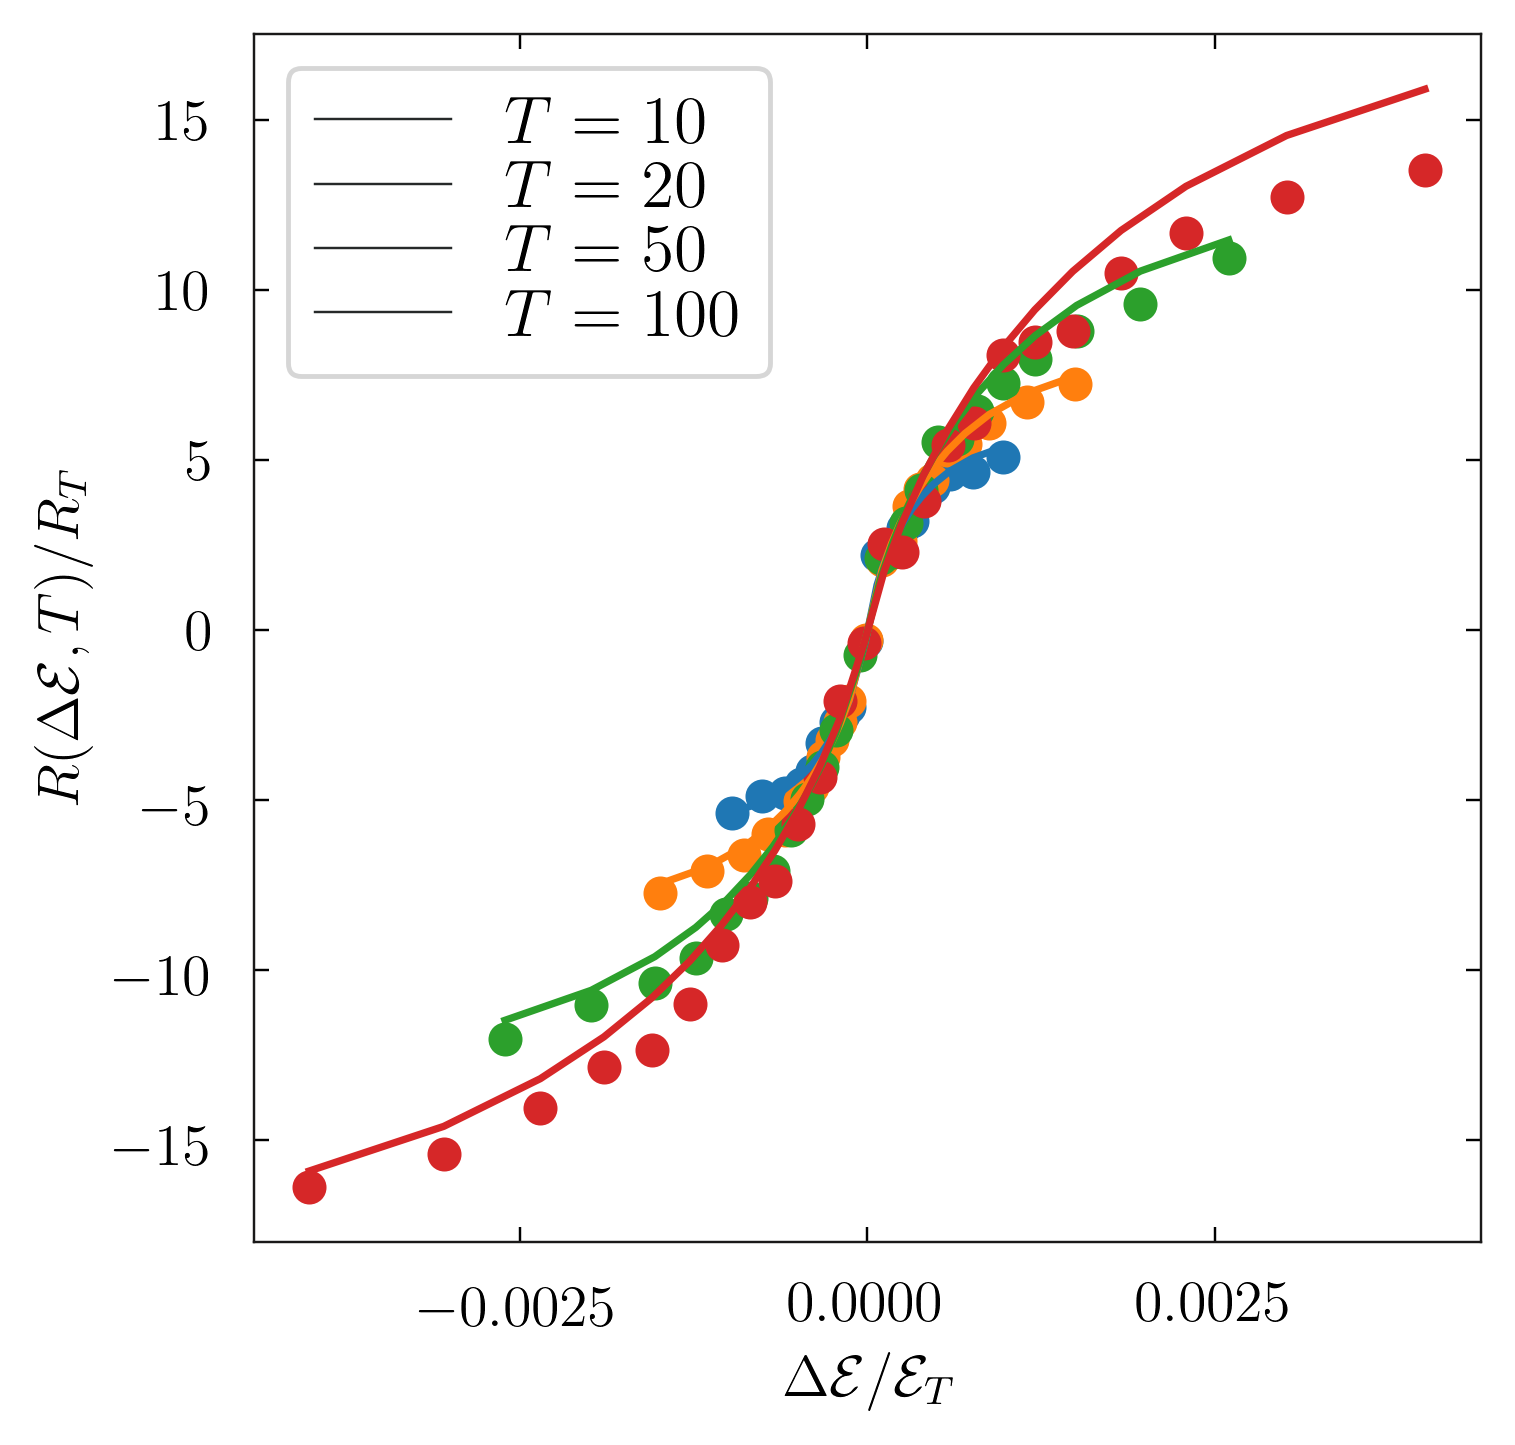

In [24]:
plot_scaling_function(prop_aggregate_impact, 
                      scaling_params=params,
                      #line_color=EBAY_COLORS.dark_color,
                      markers_color="white", 
                      imbalance_column=imbalance_column,
                      binning_frequencies=[10, 20, 50, 100])

### Transform data
To do the fss by method of least-squares, we use optimized critical paramters to rescale the scaling function onto a single master curve by initially fitting the scaling law to all $T$.

In [25]:
# Transform original data using found rescaling exponents chi 𝛘 and kapp ϰ
rescaled_data = transform(prop_aggregate_impact, rescaling_params=params, imbalance_column=imbalance_column)

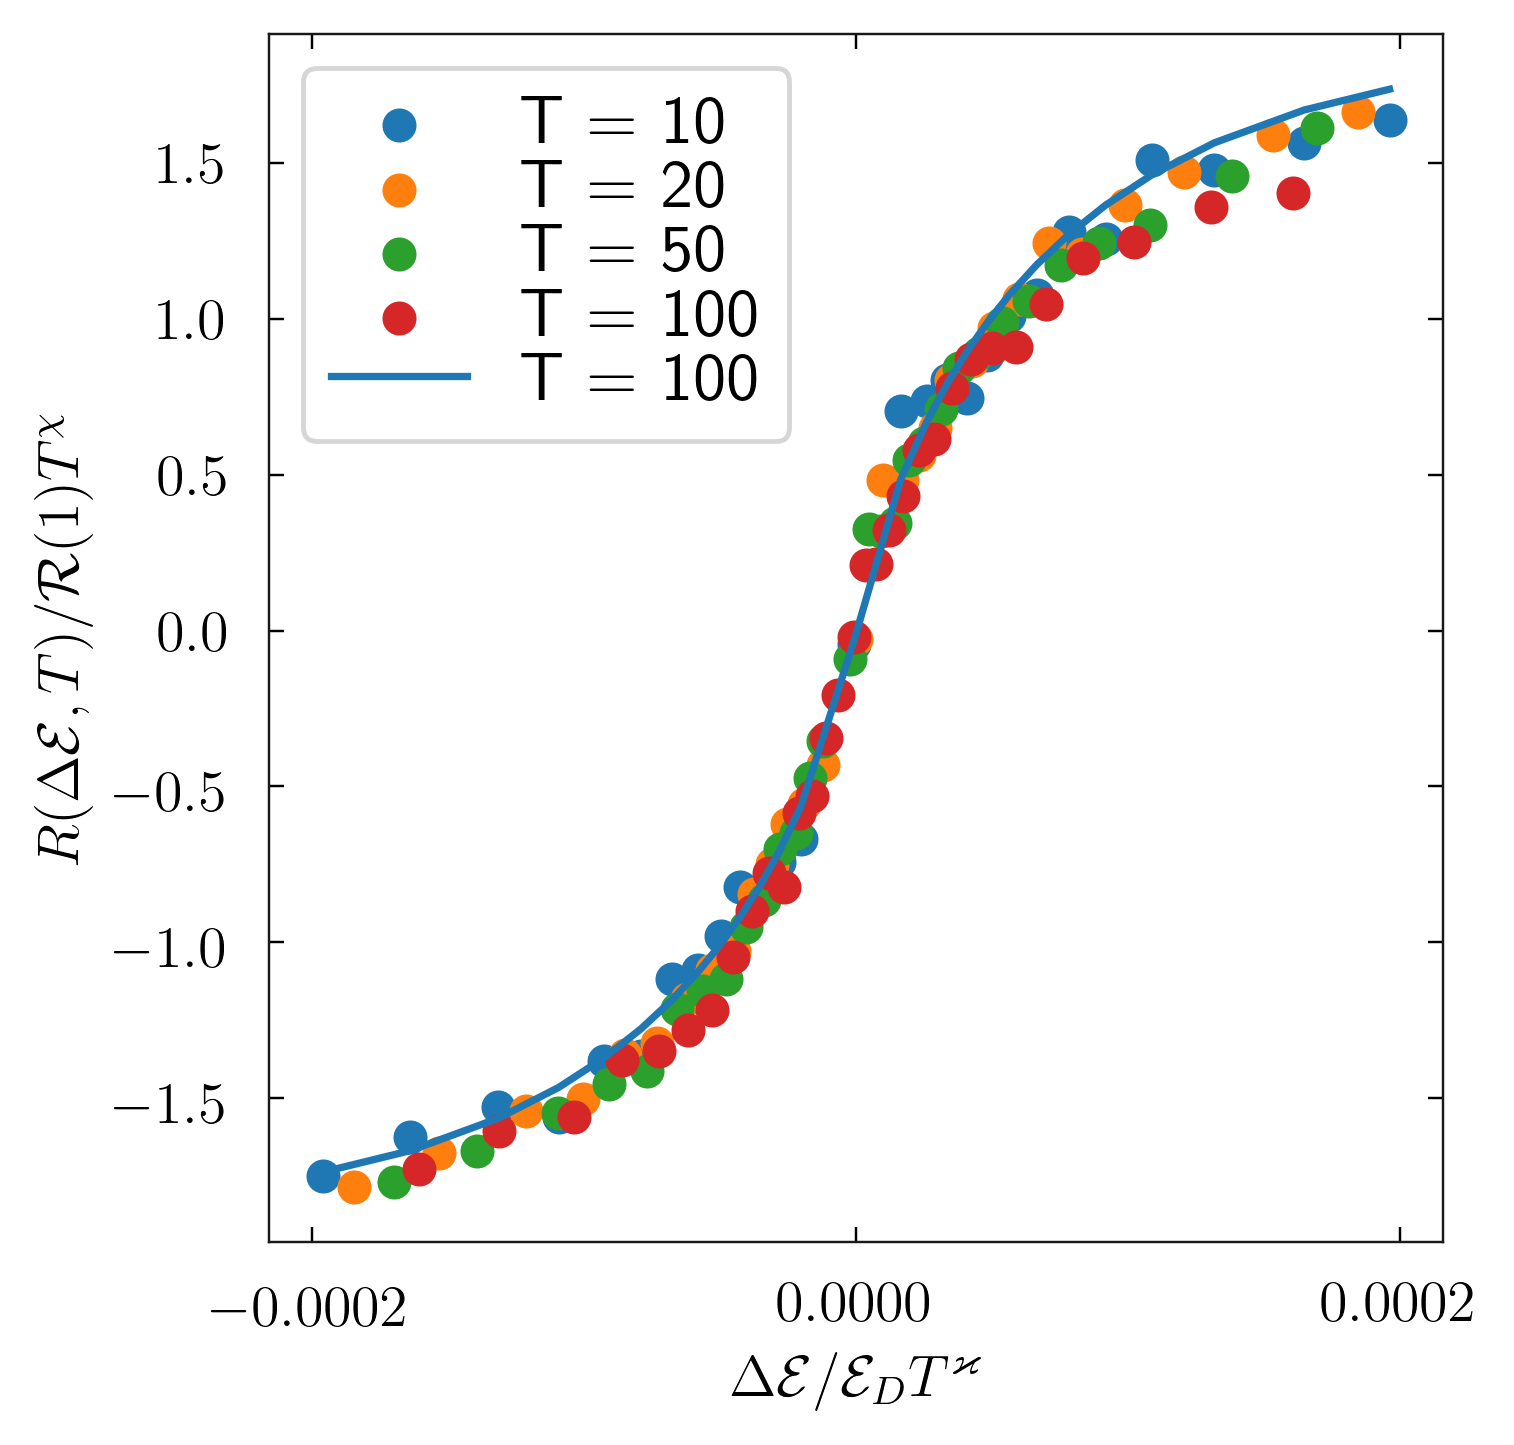

In [26]:
plot_collapsed_scaling_function(rescaled_data,  scaling_params=params,
                  #line_color=EBAY_COLORS.dark_color,
                  markers_color="white", imbalance_column=imbalance_column, 
                  master_curve=f"prop", binning_frequencies=[10, 20, 50, 100])